# Imports

In [1]:
from numpy.random import seed
seed(888)
import tensorflow as tf
tf.random.set_seed(444)

import itertools

import os
import numpy as np
import keras
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard

from sklearn.metrics import confusion_matrix

from time import strftime

# Constants

In [2]:
LOG_DIRECTORY = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH
COLOR_CHANNELS = 3
TOTAL_INPUT = IMAGE_PIXELS * COLOR_CHANNELS
NR_CLASSES = 10

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get The Data

In [3]:
(x_train_all, y_train_all), (x_test, y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 161s 1us/step


# Explor The Data

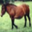

In [4]:
pic = Image.fromarray(np.uint8(x_train_all[7]))
display(pic)

In [5]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

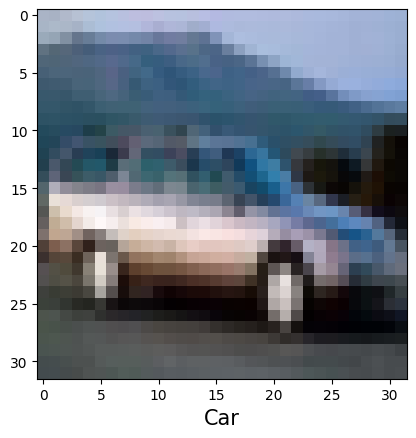

In [6]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

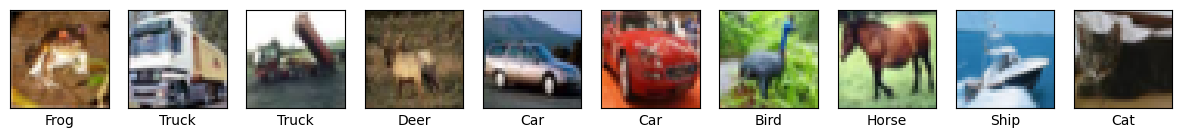

In [7]:
plt.figure(figsize=(15,5))

for i in range (10):
    plt.subplot(1, 10, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]])
    plt.imshow(x_train_all[i])
plt.show()

# Preprocess Data

In [8]:
x_train_all = x_train_all / 255.0
x_test = x_test / 255.0

x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUT)
x_test = x_test.reshape(x_test.shape[0], TOTAL_INPUT)

# Create Validation Dataset

In [9]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

In [10]:
x_train = x_train_all[VALIDATION_SIZE : ]
y_train = y_train_all[VALIDATION_SIZE : ]

In [11]:
x_train.shape

(40000, 3072)

# Create Small Dataset (For Illustration)

In [12]:
x_train_xs = x_train_all[: SMALL_TRAIN_SIZE]
y_train_xs = y_train_all[: SMALL_TRAIN_SIZE]

# Define Neural Network Using Keras

#### Model 1

In [13]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUT, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'),
    Dense(units=16, activation='relu', name='m1_hidden3'),
    Dense(units=10, activation='softmax', name='m1_output')
])

model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Model 2

In [14]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUT,)))
model_2.add(Dense(units=128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(units=64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(units=16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(units=10, activation='softmax', name='m2_output'))

model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Model 3

In [15]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUT,)))
model_3.add(Dense(units=128, activation='relu', name='m2_hidden1'))
model_3.add(Dropout(0.2, seed=42))
model_3.add(Dense(units=64, activation='relu', name='m2_hidden2'))
model_3.add(Dense(units=16, activation='relu', name='m2_hidden3'))
model_3.add(Dense(units=10, activation='softmax', name='m2_output'))

model_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Tensorboard (Visualizing Learning)

In [16]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%H %M %S")}'
    dir_path = os.path.join(LOG_DIRECTORY, folder_name)

    try:
        os.makedirs(dir_path)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully Created Directory')

    return TensorBoard(log_dir=dir_path)

# Fit The Model

In [17]:
sample_per_batch = 1000

In [18]:
# %%time
# nr_epoch = 200
#
# model_1.fit(x_train_xs, y_train_xs, batch_size=sample_per_batch, epochs=nr_epoch, verbose=0, validation_data=(x_val, y_val),
#             callbacks=[get_tensorboard("Model 1")])

In [25]:
%%time
nr_epoch = 100

model_1.fit(x_train, y_train, batch_size=sample_per_batch, epochs=nr_epoch, verbose=0, validation_data=(x_val, y_val),
            callbacks=[get_tensorboard("Model 1 XL")])

Successfully Created Directory
CPU times: total: 1min 23s
Wall time: 1min 20s


In [26]:
%%time
nr_epoch = 100

model_2.fit(x_train, y_train, batch_size=sample_per_batch, epochs=nr_epoch, verbose=0, validation_data=(x_val, y_val),
            callbacks=[get_tensorboard("Model 2 XL")])

Successfully Created Directory
CPU times: total: 4min 27s
Wall time: 2min 51s


In [27]:
%%time
nr_epoch = 100

model_3.fit(x_train, y_train, batch_size=sample_per_batch, epochs=nr_epoch, verbose=0, validation_data=(x_val, y_val),
            callbacks=[get_tensorboard("Model 3 XL")])

Successfully Created Directory
CPU times: total: 9min 57s
Wall time: 3min 21s


# Prediction On Individual Images

In [28]:
x_test.shape

(10000, 3072)

In [29]:
x_test_reshaped = np.reshape(x_test[0], (1, 3072))

In [30]:
predictions = model_3.predict(x_test).argmax(axis=1)

313/313 [==============================] - 1s 2ms/step


In [31]:
pred_vs_real = np.equal(y_test.flatten(), predictions.flatten())
num_falses = np.count_nonzero(pred_vs_real == False)
print(f'Your model predicted {10000 - num_falses} images out of 10,000 correctly \nThe Accuracy of The Model is: {"{:.1%}".format((10000 - num_falses) / 10000)}')

Your model predicted 4656 images out of 10,000 correctly 
The Accuracy of The Model is: 46.6%


# Evaluation

In [32]:
test_loss, test_accuracy = model_3.evaluate(x_test, y_test)
print(f'Test loss is {test_loss:.3} and test accuracy is {test_accuracy:.1%}')

313/313 [==============================] - 1s 3ms/step - loss: 1.4958 - accuracy: 0.4656
Test loss is 1.5 and test accuracy is 46.6%


In [33]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

In [34]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

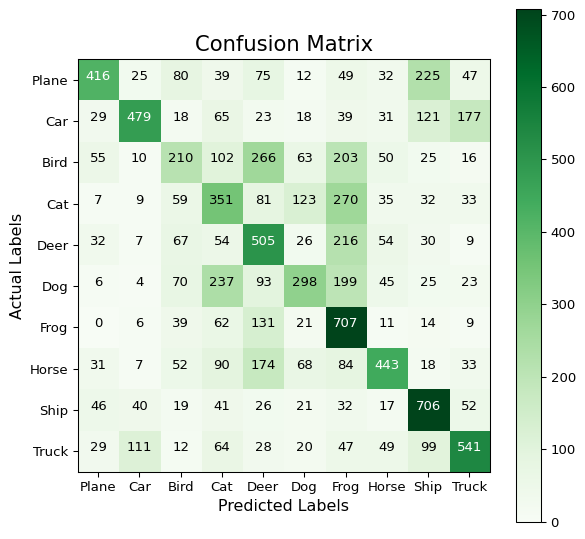

In [35]:
plt.figure(figsize=(7,7), dpi=95)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')


plt.show()

In [36]:
# True Positives
np.diag(conf_matrix)

array([416, 479, 210, 351, 505, 298, 707, 443, 706, 541], dtype=int64)

In [37]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.416, 0.479, 0.21 , 0.351, 0.505, 0.298, 0.707, 0.443, 0.706,
       0.541])

In [38]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.6390169 , 0.68624642, 0.33546326, 0.31764706, 0.36019971,
       0.44477612, 0.38299025, 0.57757497, 0.54517375, 0.57553191])

In [39]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall:.2%}')

Model 2 recall score is 46.56%


In [40]:
avg_precision = np.mean(precision)
print(f'Model 3 precision score is {avg_precision:.2%}')

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print(f'Model 3 f score is {f1_score:.2%}')

Model 3 precision score is 48.65%
Model 3 f score is 47.58%
